Dennis Wang

Dataset from https://www.kaggle.com/datasets/samuelotiattakorah/healthcare-no-show-appointment-data

Data is not iid and large (100k+ rows)


In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.26.4", 'matplotlib': "3.9.2",'sklearn': "1.5.1", 
                'pandas': "2.2.2",'xgboost': "2.1.1", 'shap': "0.45.1", 
                'plotly': "5.23.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] numpy version 1.26.4 is installed.
[ OK ] matplotlib version 3.9.2 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.
[ OK ] xgboost version 2.1.1 is installed.
[ OK ] shap version 0.45.1 is installed.
[ OK ] plotly version 5.23.0 is installed.


## EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/healthcare_noshows_appointments.csv', dtype={'PatientId': str, 'AppointmentID': str})
#df['PatientId'] = df['PatientId'].astype(int).astype(str)
display(df.head())
display(df.shape)
display(df.info())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


(106987, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientId       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hipertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handcap         106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  Showed_up       106987 non-null  bool  
 14  Date.diff       106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


None

The inconsistency of the columns names are really annoying me so I'm renaming them.

In [13]:
df = df.rename(columns={"PatientId": "PatientID", "Showed_up": "ShowedUp", "Date.diff": "DateDiff","Hipertension":"Hypertension"})
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientID       106987 non-null  object
 1   Gender          106987 non-null  object
 2   ScheduledDay    106987 non-null  object
 3   AppointmentDay  106987 non-null  object
 4   Age             106987 non-null  int64 
 5   Neighbourhood   106987 non-null  object
 6   Scholarship     106987 non-null  bool  
 7   Hypertension    106987 non-null  bool  
 8   Diabetes        106987 non-null  bool  
 9   Alcoholism      106987 non-null  bool  
 10  Handcap         106987 non-null  bool  
 11  SMS_received    106987 non-null  bool  
 12  ShowedUp        106987 non-null  bool  
 13  DateDiff        106987 non-null  int64 
dtypes: bool(7), int64(2), object(5)
memory usage: 6.4+ MB


None

It seems a lot of our columns are binary. We know each row represents each appointment, but to check if there's overlap between patients:

In [5]:
display(len(df['PatientID'].unique()))
display(len(df['AppointmentID'].unique()))

60270

106987

Since some patients appear more than once in the dataset, we will have to stratify by patient when splitting later on.

Immediately drop column 'AppointmentID' because we don't need the unique appointment identifier.

I'm considering dropping columns 'ScheduledDay' and 'AppointmentDay' because DateDiff relies on those two columns and sees like an easier attribute to work with.
But maybe we can do something with the day of the week of either the ScheduledDay or AppointmentDay?

In [6]:
df = df.drop(['AppointmentID'], axis=1)

In [32]:
df = df[['PatientID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'DateDiff', 'Age',
       'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received','ShowedUp']]
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

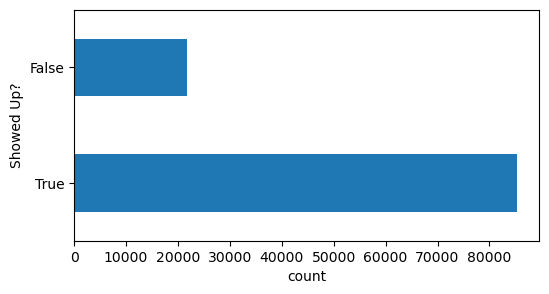

In [7]:
# visualizing our target variable
plt.figure(figsize=(6,3))
df['ShowedUp'].value_counts().plot.barh()
plt.xlabel('count')
plt.ylabel('Showed Up?')
plt.show()
# is it okay if i don't have a caption if I talk about the plot in the markdown?

Looks like our categorical target variable, ShowedUp, is highly imbalanced. Most people thankfully show up to their appointment.

It makes sense that patients with more previous readmissions in the past 180 days would have longer stays in the hospital, but what's more interesting is that as the 'rcount' increases, the variability in 'lengthofstay' generally decreases.

I know that obesity is one the leading factors in all-cause mortality in the United States. I wonder if there's a relationship between BMI and length of stay, or potentially other variables in our dataset.

In [8]:
df.loc[:, df.isnull().any() ]

""
0
1
2
3
4
...
106982
106983
106984
106985


no nulls

# Testing relationships between our features and target variable

<Figure size 2000x1200 with 0 Axes>

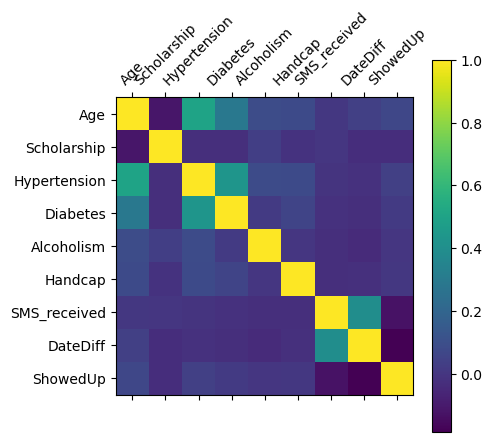

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,DateDiff,ShowedUp
Age,1.000000,-0.112699,0.502091,0.290631,0.090391,0.079726,0.005251,0.038880,0.067025
Scholarship,-0.112699,1.000000,-0.024530,-0.027622,0.033527,-0.010465,-0.000010,-0.030439,-0.029370
Hypertension,0.502091,-0.024530,1.000000,0.430827,0.085459,0.082909,-0.008805,-0.016996,0.037280
Diabetes,0.290631,-0.027622,0.430827,1.000000,0.016874,0.057945,-0.016136,-0.027339,0.015928
Alcoholism,0.090391,0.033527,0.085459,0.016874,1.000000,0.002864,-0.027403,-0.038949,0.000517
Handcap,0.079726,-0.010465,0.082909,0.057945,0.002864,1.000000,-0.026256,-0.021101,0.007620
SMS_received,0.005251,-0.000010,-0.008805,-0.016136,-0.027403,-0.026256,1.000000,0.396482,-0.127253
DateDiff,0.038880,-0.030439,-0.016996,-0.027339,-0.038949,-0.021101,0.396482,1.000000,-0.185704
ShowedUp,0.067025,-0.029370,0.037280,0.015928,0.000517,0.007620,-0.127253,-0.185704,1.000000


In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
df_num = df[['Age','Scholarship','Hypertension','Diabetes','Alcoholism','Handcap','SMS_received', 'DateDiff', 'ShowedUp']]

pearson_corr = df_num.corr(method='pearson')

plt.figure(figsize = (20,12))
plt.matshow(pearson_corr)
plt.xticks(range(df_num.shape[1]), df_num.columns, rotation = 45)
plt.yticks(range(df_num.shape[1]), df_num.columns)
cb = plt.colorbar()
plt.show()

## or use .background_gradient()? I really prefer having the correlation # in the cell 
# but not sure how to do that with .matshow() without it getting too complicated
pearson_corr.style.background_gradient(cmap='coolwarm')

# or i could use seaborn...


Not that much correlation between our features.

How about linear correlations between our features and the target variable?

In [34]:
Y

,ShowedUp
0,True
1,True
2,True
3,True
4,True
...,...
106982,True
106983,True
106984,True
106985,True


Text(0, 0.5, 'F-statistic')

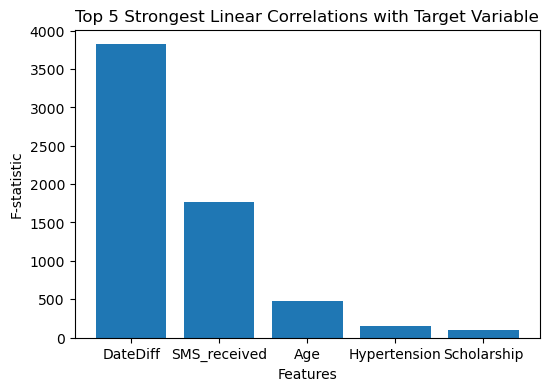

In [47]:
from sklearn.feature_selection import f_regression

X_nums = df_num.drop(['ShowedUp'], axis=1)
Y_nums = np.ravel(df_num.iloc[:,-1:])

f_statistic, p_values = f_regression(X_nums, Y_nums)

cols = X_nums.columns
f_df = pd.DataFrame(data = f_statistic, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=f_df.index, height = f_df[0])
plt.title('Top 5 Strongest Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('F-statistic')


How about non-linear correlations? i.e. mutual information

Text(0, 0.5, 'Estimated Mutual Information')

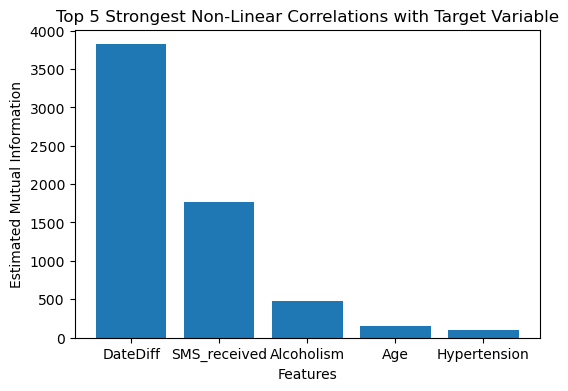

In [48]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X_nums, Y_nums)

cols = X_nums.columns
mi_df = pd.DataFrame(data = mi, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=mi_df.index, height = f_df[0])
plt.title('Top 5 Strongest Non-Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('Estimated Mutual Information')

Both plots look similar, with DateDiff and SMS_received being our features most correlated with the target variable, ShowedUp. This aligns with our pearson correlation plot.